# Mean-field Variational Inference for a Mixture of Gaussians

We implement mean-field variational inference for detecting the centers of a specified number of clusters based on a Gaussian mixture model. Work done by Rachel Levanger for Fall 2016 Foundation of Graphical Models at Columbia University, HW #3.

In [1]:
import math
import numpy as np
from scipy.stats import multivariate_normal
import pandas as pd
from scipy import misc
from scipy import spatial

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Some functions we'll use later

In [2]:
# Randomly choose num_clusters points according to N(0,variance*I) distribution in R^dims
def get_cluster_means(num_clusters, variance, dims):
    multi_v_sample = np.random.multivariate_normal(np.zeros(dims), variance*np.identity(dims) , num_clusters).T
    return multi_v_sample

## Import the dataset

We use the feature vectors generated from the topological data from the mid-plane temperature field of Rayleigh-Benard Convection.

In [3]:
sDir = '/Users/birdbrain/Documents/Research/Projects/Schatz/Data/g21chaotic/r4000_2016_11_01_superfast/g21flow'
sFeatures = 'feature_vectors_3_orientations/%06d.txt'
sOrientation = 'orientation_field_3/%06d.bmp'
sTemperature = 'bmps/%06d.bmp'



In [4]:
allFeatures = []

for idx in range(1000, 1999, 50):
    features = pd.read_csv(sDir + "/" + (sFeatures % idx), sep=' ', header=None)
    features = np.asarray(features)
    if len(allFeatures) == 0:
        allFeatures = features
    else:
        allFeatures = np.append(allFeatures, features, axis=0)

print allFeatures.shape


(1884, 329)


In [5]:
# Filter by defect type

d = 6
myFeatures = allFeatures[(allFeatures[:,d]==1) | (allFeatures[:,d+2]==1), :]

myFeatures = np.hstack((myFeatures[:, 0:3], myFeatures[:,14:]))

X = myFeatures
X = X[:,3:]
print myFeatures[0,:]
print X[0,:]
# X = myFeatures[:, featureStart:]
# X = np.hstack((X[:,0:32],X[:,32:]/1.))

[1000  380  266    8   23   18   14   11    7    5    3    1    1   34   29
   24   19   14    9    5    2    0  255  255  255    0   42   37   32   26
   20   14    8    2  255  252  249  249  250  252  255   51   46   41   35
   28   20   13    5  255  249  245  242  240  241  245  250    0   56   51
   46   38   30   21   11    2  250  243  237  233  231  231  235  243  255
   66   62   57   51   43   32   21    9  255  245  237  231  226  223  222
  225  235  253   13   72   69   65   58   48   34   19    5  250  241  233
  226  220  217  215  217  228  255   22   79   77   74   68   54   33   12
  255  245  237  230  223  217  213  211  212  223    9   33   86   87   87
   82   61   18  255  246  240  234  228  222  217  212  208  208  222   33
   45   93   95   99  105  113  176  233  236  237  235  233  229  224  219
  213  209  207  238   56   56  105  114  133  162  197  217  226  231  233
  233  231  228  224  218  213  207   74   70   65  115  133  158  184  203
  215  224  

In [6]:
N = X.shape[0]
dim = X.shape[1]

print X[0,:]
print X.shape

[  8  23  18  14  11   7   5   3   1   1  34  29  24  19  14   9   5   2
   0 255 255 255   0  42  37  32  26  20  14   8   2 255 252 249 249 250
 252 255  51  46  41  35  28  20  13   5 255 249 245 242 240 241 245 250
   0  56  51  46  38  30  21  11   2 250 243 237 233 231 231 235 243 255
  66  62  57  51  43  32  21   9 255 245 237 231 226 223 222 225 235 253
  13  72  69  65  58  48  34  19   5 250 241 233 226 220 217 215 217 228
 255  22  79  77  74  68  54  33  12 255 245 237 230 223 217 213 211 212
 223   9  33  86  87  87  82  61  18 255 246 240 234 228 222 217 212 208
 208 222  33  45  93  95  99 105 113 176 233 236 237 235 233 229 224 219
 213 209 207 238  56  56 105 114 133 162 197 217 226 231 233 233 231 228
 224 218 213 207  74  70  65 115 133 158 184 203 215 224 229 233 234 235
 234 231 228 224  71  81  77  73 125 148 175 195 208 217 224 229 233 236
 238 239 239 240   0  80  85  83  80 136 159 185 202 212 220 226 231 234
 238 240 243 246 254  48  85  89  88  86 166 191 20

## Plot a projection of the data

(0.0, 300.0, 0.0, 300.0)

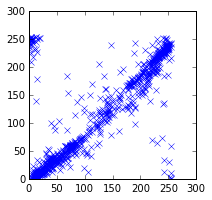

In [7]:
# Plot the means
plt.rcParams['figure.figsize'] = (3.0, 3.0)
plt.plot(X[:,0], X[:,1], 'x', markerfacecolor='blue')
plt.axis('equal')

## Implement mean-field variational inference

### Initialize the algorithm

In [8]:
# Set the minimum number of iterations
iterations = 20
K = 20

# Set the prior parameters
p_sigma = 1. # Variance of cluster of means

# Initialize the variational parameters
vi_m = np.zeros((iterations, K, dim)) # Cluster means, initialized to random points.
vi_m[0,:,:] = get_cluster_means(K, math.pow(p_sigma,2), dim).T
vi_m[0,:,:] = vi_m[0,:,:] + np.mean(X, axis=0)

vi_s_2 = np.zeros((iterations, K)) # Cluster variances, first initialized to one.
vi_s_2[0,:] = np.ones(K)

vi_phi = np.zeros((iterations, N, K)) # Assignment distributions, first initialized to categorical uniform
vi_phi[0,:,:] = np.ones((N,K))*(1./K)

# ELBO table
ELBO = np.zeros(iterations-1)

### Iterate the CAVI algorithm to get variational estimator for posterior

In [9]:
# Iterate the CAVI algorithm
for t in range(1,iterations):
    

    print t
    
    # Update the vi_phi: posterior assignment distributions
    for n in range(N):
        
        for k in range(K):
            log_sum_exp_argument = [np.dot(X[n],vi_m[t-1,j,:]) - (dim*vi_s_2[t-1,j] + np.dot(vi_m[t-1,j,:],vi_m[t-1,j,:]))/2. for j in range(K)]
            max_log_sum_exp = max(log_sum_exp_argument)
            log_sum_exp_sum = sum([math.exp(x - max_log_sum_exp) for x in log_sum_exp_argument])
            vi_phi_log = np.dot(X[n],vi_m[t-1,k,:]) - (dim*vi_s_2[t-1,k] + np.dot(vi_m[t-1,k],vi_m[t-1,k]))/2. - max_log_sum_exp - math.log(log_sum_exp_sum)
            vi_phi[t,n,k] = math.exp(vi_phi_log)
        
    # Update the vi_m and vi_s_2: posterior means and variances 
    vi_m[t,:,:] = vi_m[t-1,:,:]
    for k in range(K):
        
        sum_phi_x = np.zeros(dim)
        for n in range(N):
            sum_phi_x = sum_phi_x + vi_phi[t,n,k]*X[n]
        vi_m[t,k] = (sum_phi_x)/(p_sigma**(-2) + sum(vi_phi[t,:,k]))
        vi_s_2[t,k] = 1./(p_sigma**(-2) + sum(vi_phi[t,:,k]))
    
    # Update the ELBO
    for k in range(K):
        ELBO[t-1] = ELBO[t-1] + (-1./2.)*math.log(2*math.pi*(p_sigma**2)) - (np.dot(vi_m[t,k],vi_m[t,k]) + dim*vi_s_2[t,k])/(2.*p_sigma**2)
        ELBO[t-1] = ELBO[t-1] + (1./2.)*math.log(2*math.pi*vi_s_2[t,k]) + (1./2.)
    for n in range(N):
        ELBO[t-1] = ELBO[t-1] + math.log(1./K)
        ELBO[t-1] = ELBO[t-1] - sum([phi*math.log(phi) for phi in vi_phi[t,n,vi_phi[t,n,:] > 0]])
        ELBO[t-1] = ELBO[t-1] + sum([vi_phi[t,n,k]*((-1./2.)*math.log(2*math.pi) - np.dot(X[n],X[n])/2. + np.dot(X[n],vi_m[t,k]) - (dim*vi_s_2[t,k] + np.dot(vi_m[t,k],vi_m[t,k]))/2.) for k in range(K)])
    

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


## Plot the results!

In [10]:
# Get the expectations of the categories for each data point
z = np.zeros(N)

for n in range(N):
#     z[n] = np.random.multinomial(1,vi_phi[iterations-1,n,:]).nonzero()[0][0]
    z[n] = np.argmax(vi_phi[iterations-1,n,:])
    
z = z.astype(np.int)


(0.0, 300.0, 0.0, 300.0)

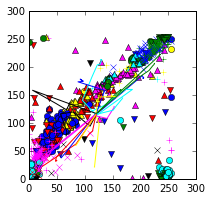

In [11]:
plt.rcParams['figure.figsize'] = (3.0, 3.0)

fig,ax = plt.subplots(1)
ax.set_aspect('equal')

color=['cyan', 'blue', 'magenta', 'green', 'red', 'yellow', 'black']
marker=['o','x','+','v','^']


# Plot the datapoints with color chosen according to variational distribution
for n in range(N):
    ax.plot(X[n,0], X[n,50], 'x', marker=marker[z[n] % len(marker)], color=color[z[n] % len(color)])

# Plot the mean history for the variational inference algorithm
for k in range(K):
    ax.plot(vi_m[:,k,0],vi_m[:,k,1], color=color[k % len(color)])
    circle = matplotlib.patches.Ellipse([vi_m[iterations-1,k,0], vi_m[iterations-1,k,1]], 2.*np.sqrt(vi_s_2[iterations-1,k]), 2.*np.sqrt(vi_s_2[iterations-1,k]), alpha=0.25, color=color[k % len(color)])
    ax.add_patch(circle)

ax.axis('equal')


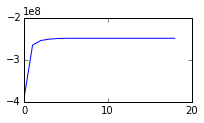

In [12]:
plt.rcParams['figure.figsize'] = (3.0, 1.5)
plt.plot(ELBO[:])
plt.locator_params(nbins=3)
plt.savefig('/Users/birdbrain/Documents/School/Columbia/GraphicalModels/Project/writeup/figures/%d/elbo.png' % (d), bbox_inches = 'tight', pad_inches = 0)


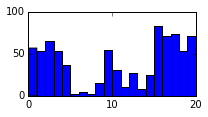

In [13]:
plt.rcParams['figure.figsize'] = (3.0, 1.5)
plt.hist(z, range(K+1))
plt.locator_params(nbins=3)
plt.savefig('/Users/birdbrain/Documents/School/Columbia/GraphicalModels/Project/writeup/figures/%d/hist.png' % (d), bbox_inches = 'tight', pad_inches = 0)


Cluster 1


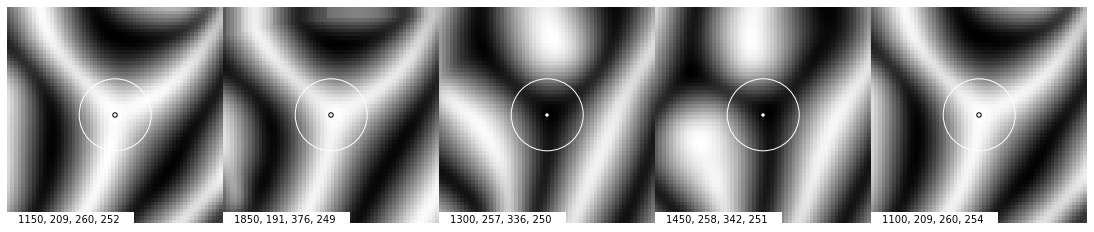

Cluster 2


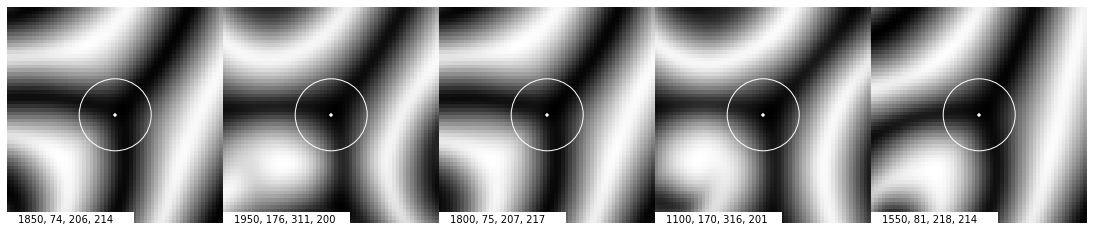

Cluster 3


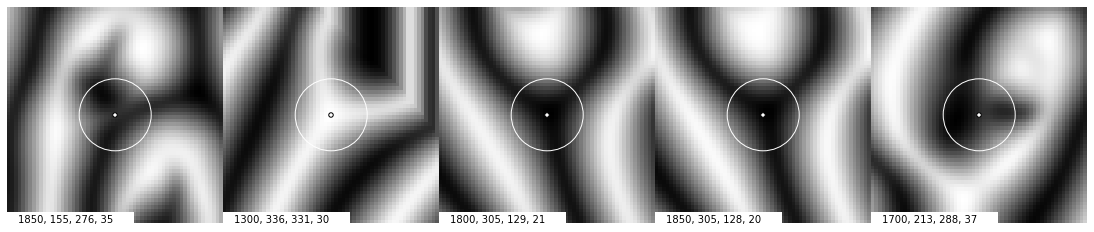

Cluster 4


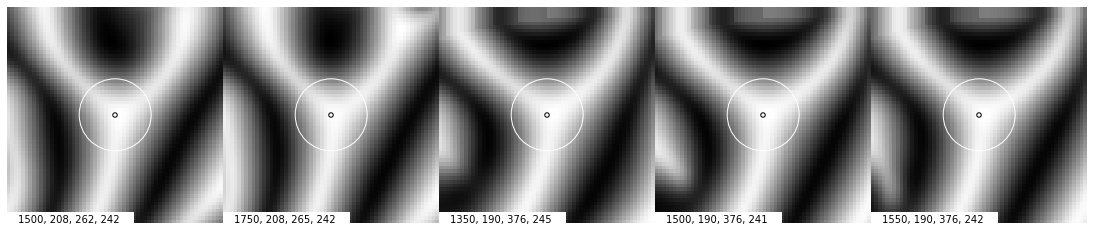

Cluster 5


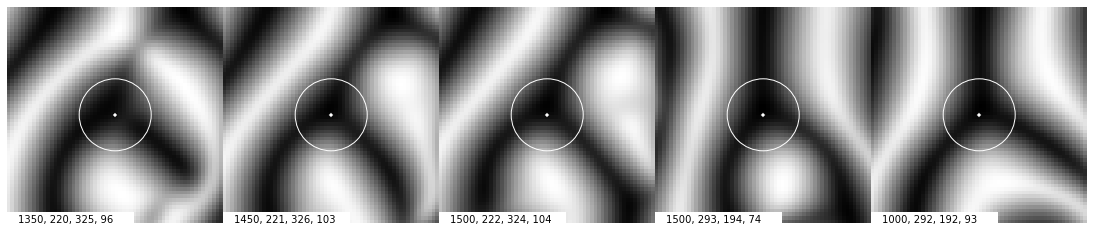

Cluster 6


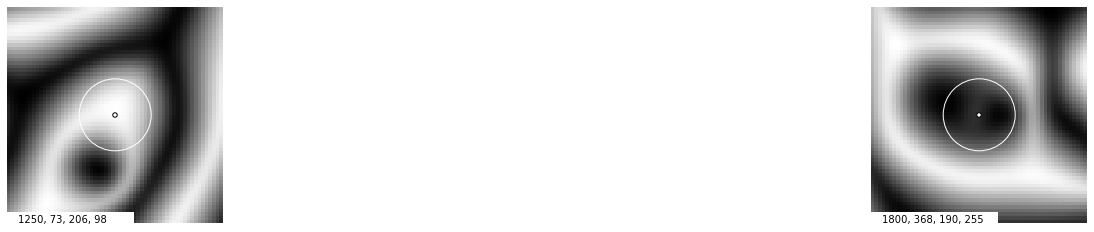

Cluster 7


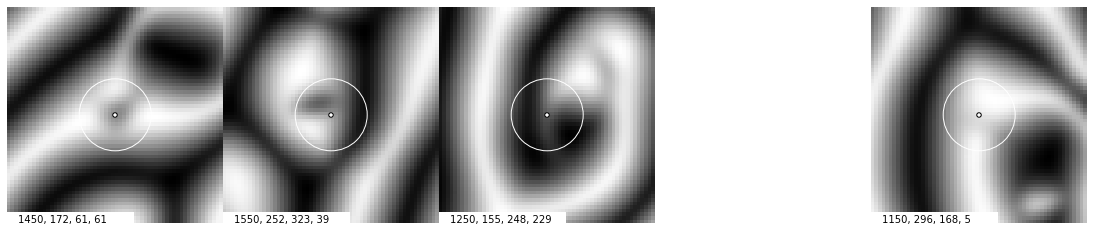

Cluster 8


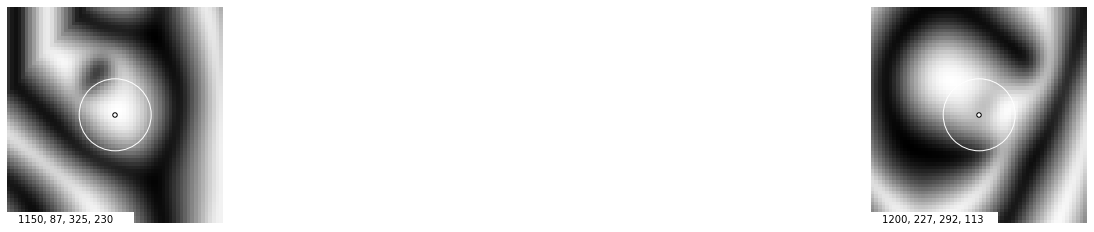

Cluster 9


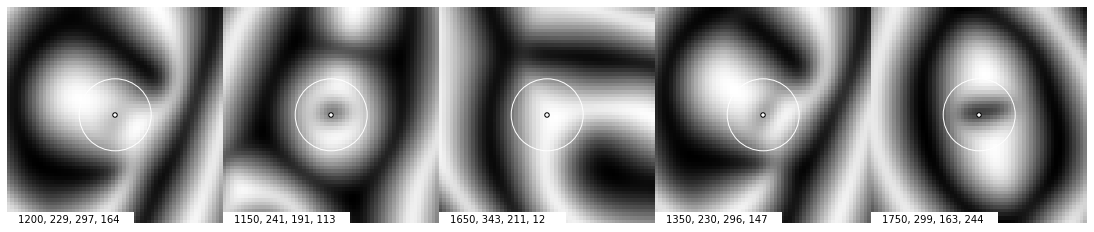

Cluster 10


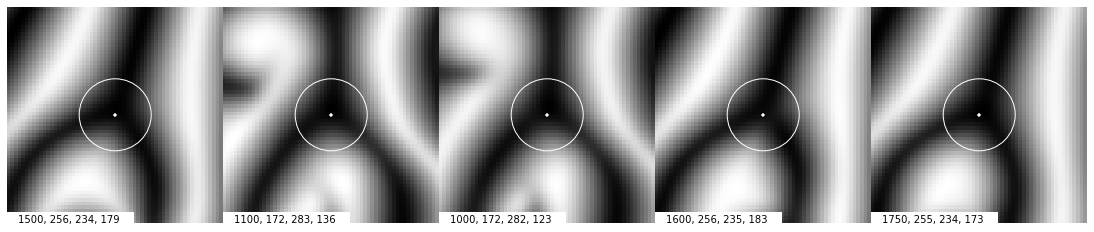

Cluster 11


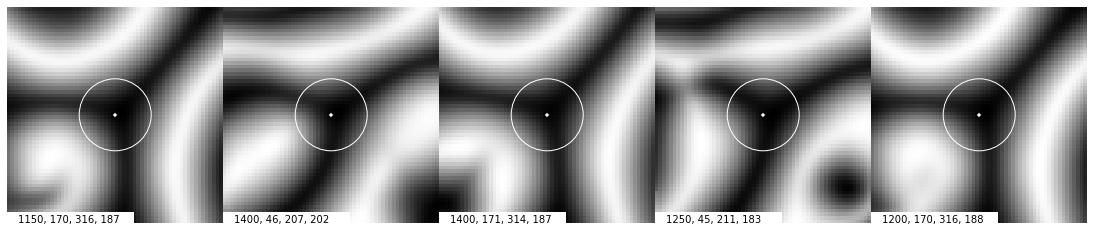

Cluster 12


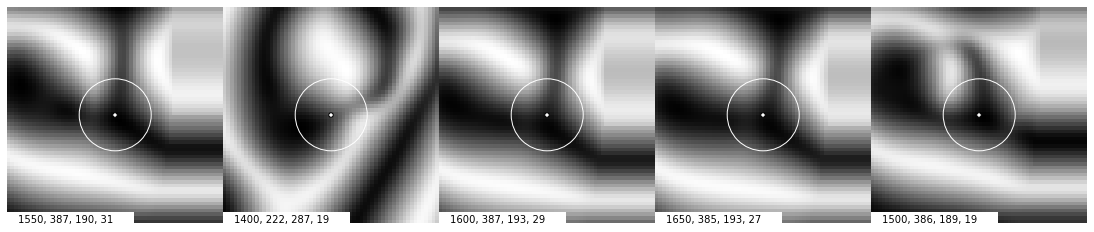

Cluster 13


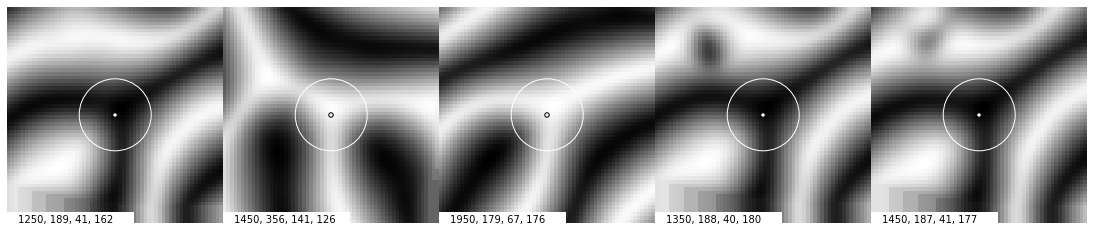

Cluster 14


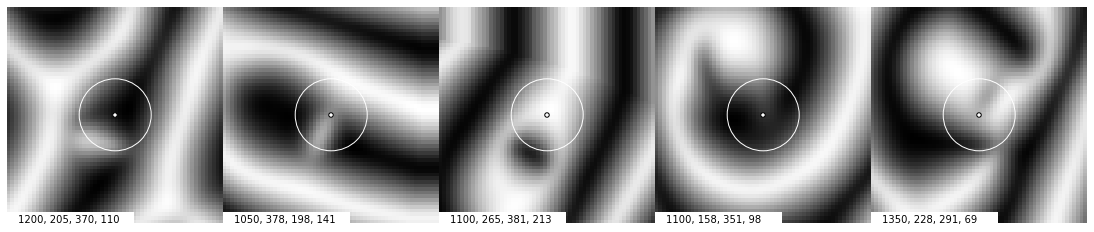

Cluster 15


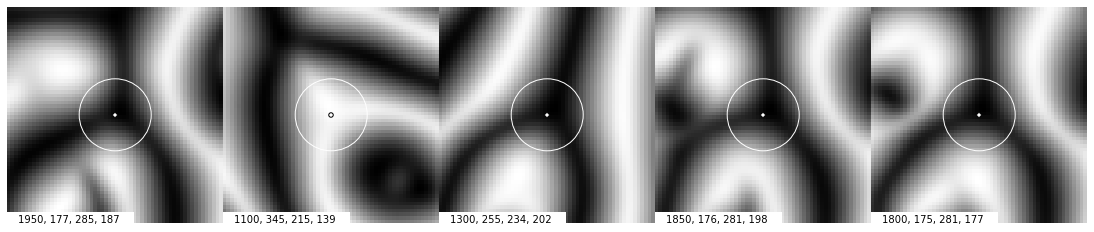

Cluster 16


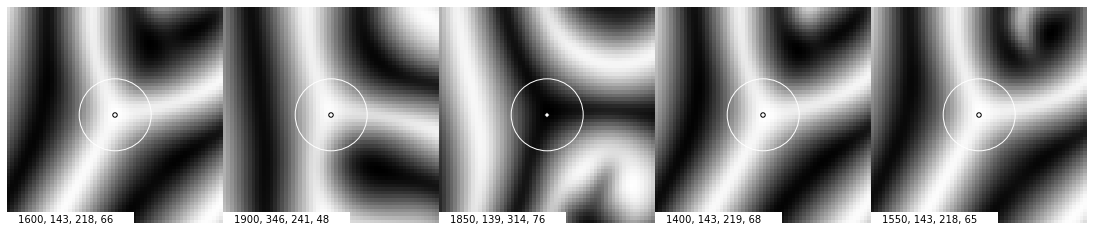

Cluster 17


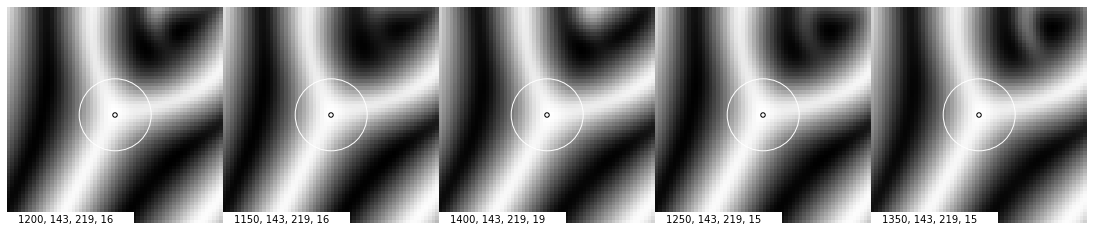

Cluster 18


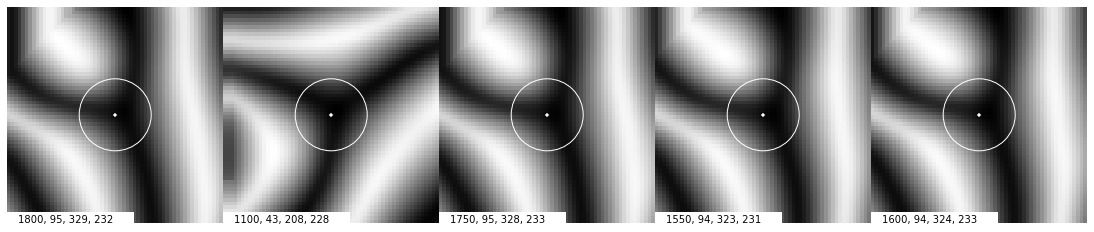

Cluster 19


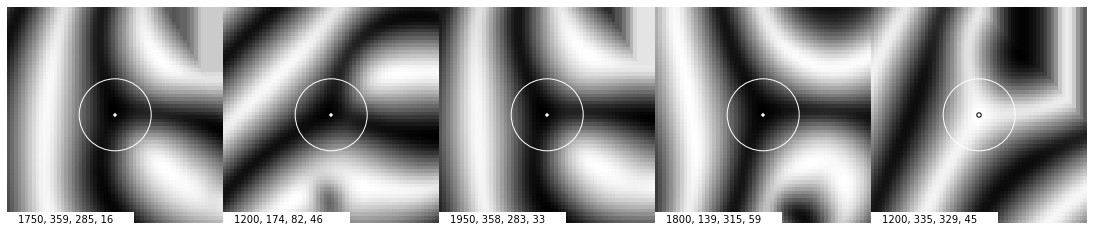

Cluster 20


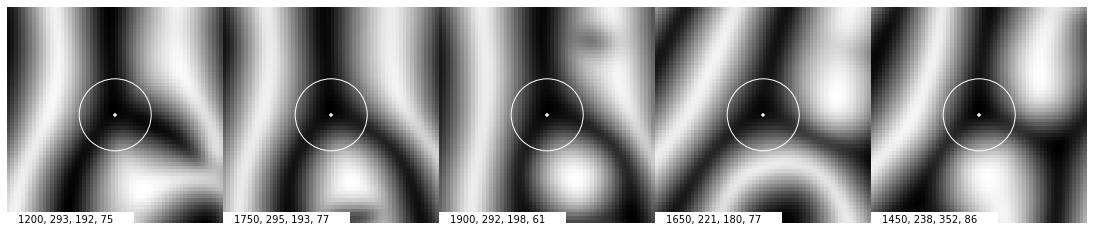

In [14]:
n = 5

plt.rcParams['figure.figsize'] = (15.0, 3.0)

for k in range(K):
    
    
    samples = myFeatures[np.argwhere(z==k),0:4]
    samples = samples.reshape((samples.shape[0],4))
        
    if len(samples) > 0:

        # Get n samples from cluster k that are closest to the mean of that cluster
        m_k = vi_m[-1,k]
        
#         if m_k[0] > 100:

#             print 'Cluster %d, LyapValue=%d' % (k+1, m_k[0])
        print 'Cluster %d' % (k+1)

        features = np.reshape(myFeatures[np.argwhere(z==k),3:], (myFeatures[np.argwhere(z==k),3:].shape[0], myFeatures[np.argwhere(z==k),3:].shape[2]))
        tree = spatial.KDTree(features)

        n_neighbors = min(n, features.shape[0])
        nn = tree.query(m_k, n_neighbors)

        for i in range(n_neighbors):

            if len(samples)==1:
                sample = nn[1]
            else:
                sample = nn[1][i]

            radius = 30
            tmp_radius = radius

            x = samples[sample,1]
            y = samples[sample,2]

            temp = misc.imread(sDir + "/" + (sTemperature % samples[sample,0]))

            plt.subplot(1,n,i)
#             fig = plt.figure()
            plt.set_cmap('gray')
            plt.pcolor(temp[(y-radius):(y+radius), (x-radius):(x+radius)].astype(np.int))
            plt.scatter(radius, radius, color='white', edgecolor='black')
            plt.gca().set_axis_off()
            plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                        hspace = 0, wspace = 0)
            plt.margins(0,0)

#             plt.plot([tmp_radius - tmp_radius/3., tmp_radius + tmp_radius/3.], [tmp_radius, tmp_radius], color='white', lw=1)
#             plt.plot([tmp_radius, tmp_radius], [tmp_radius - tmp_radius/3., tmp_radius + tmp_radius/3.], color='white', lw=1)
            ax = plt.gca()
            circle1 = plt.Circle((tmp_radius, tmp_radius), tmp_radius/3., color='white', fill=False, lw=1)
            ax.add_artist(circle1)

#             circle2 = plt.Circle((tmp_radius, tmp_radius), 0.5*tmp_radius/3., color='white', fill=False, lw=1)
#             ax.add_artist(circle2)

            plt.fill([0,radius+5,radius+5,0], [0,0,3,3], color='white')
            plt.annotate(', '.join([str(int(x)) for x in samples[sample,0:4]]),(3,0))

            plt.gca().xaxis.set_major_locator(plt.NullLocator())
            plt.gca().yaxis.set_major_locator(plt.NullLocator())

            plt.axis('off')

#             fig.tight_layout()
#             plt.savefig('/Users/birdbrain/Documents/School/Columbia/GraphicalModels/Project/writeup/figures/%d/%d_%d.png' % (d, k+1, i+1), bbox_inches = 'tight', pad_inches = 0)


        plt.show()